In [1]:
# Change from V5
# - Instance filted by min area

In [1]:
import numpy as np
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg, CfgNode
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling.backbone import fpn_resneSt
from detectron2.structures.instances import Instances

import pandas as pd
import pickle
import pycocotools.mask as mask_util
from tqdm.notebook import tqdm
from sklearn.neighbors import KDTree

In [2]:
import sys
sys.path.append('/tf/SartoriusCIS/utils/')
from metric_by_outputs import calculate_AP

In [3]:
ROOT_FOLDER = '/tf/SartoriusCIS/'
ANN_DIR = f'{ROOT_FOLDER}/data/annotation'
DATA_DIR = f'{ROOT_FOLDER}/data/LiveCell_OriginalData_Merged/images'

# PKL_FOLDER = 'valid_outputs/ens_v4.3_v13_v16_pixel_score/'
VER = '5_ens_m1022_m1018'

In [4]:
def get_pkl_folder(d):
    category_id = d['annotations'][0]['category_id']
    return 'valid_outputs/ens_v21_v16_pixel_score/'


In [5]:
dataDir=Path(DATA_DIR)

register_coco_instances('sartorius_val_1',{}, f'{ANN_DIR}/valid/val_fold0_split_part1.json', dataDir)
register_coco_instances('sartorius_val_2',{}, f'{ANN_DIR}/valid/val_fold0_split_part2.json', dataDir)

metadata = MetadataCatalog.get('sartorius_val_1')
valid_ds1 = DatasetCatalog.get('sartorius_val_1')
valid_ds2 = DatasetCatalog.get('sartorius_val_2')

In [7]:
# outputs['instances'].pred_masks

In [8]:
def calculate_max_IOU_with_gt(targ, pred):
    pred_masks = pred['instances'].pred_masks >= 0.5
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    
    return ious.max(axis=1)

def print_log(log):
    for k in log.keys():
        print(k, log[k])
        
def get_overlapping_features(pred):
    pred_masks = pred['instances'].pred_masks >= 0.5
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    ious = mask_util.iou(enc_preds, enc_preds, [0]*len(enc_preds))
    return ious.max(axis=1), ious.min(axis=1), ious.mean(axis=1),\
             ious.std(axis=1), (ious > 0).sum(axis=1)

def get_contour_features(pred):
    masks = (pred['instances'].pred_masks.numpy() >= 0.5).astype('uint8')
    
    data_dict = {
        'centroid_x':[],
        'centroid_y':[],
        'num_contours': [],
        'equi_diameter':[],
        'hull_area':[],
        'solidity':[],
        'is_convex':[],
        'perimeter':[],
        'rotation_ang':[],
        'major_axis_length':[],
        'minor_axis_length':[]
    }
    
    for mask in masks:
        contours, _ = cv2.findContours(mask, 1, 2)
        areas = [cv2.contourArea(cnt) for cnt in contours]
        max_ind = np.argmax(areas)
        
        area = areas[max_ind]
        cnt = contours[max_ind]
        
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area if hull_area > 0 else -1
        
        equi_diameter = np.sqrt(4*area/np.pi)
        is_convex = int(cv2.isContourConvex(cnt))
        perimeter = cv2.arcLength(cnt,True)
        
        try:
            ellipse = cv2.fitEllipse(cnt)
            _,(major_axis_length, minor_axis_length), rotation_ang = ellipse
        except:
            (major_axis_length, minor_axis_length), rotation_ang = (-1,-1),-1
        
        data_dict['centroid_x'].append(cx)
        data_dict['centroid_y'].append(cy)
        data_dict['num_contours'].append(len(contours))
        data_dict['equi_diameter'].append(equi_diameter)
        data_dict['solidity'].append(solidity)
        data_dict['hull_area'].append(hull_area)
        data_dict['is_convex'].append(is_convex)
        data_dict['perimeter'].append(perimeter)
        data_dict['rotation_ang'].append(rotation_ang)
        data_dict['major_axis_length'].append(major_axis_length)
        data_dict['minor_axis_length'].append(minor_axis_length)
        
    return pd.DataFrame(data_dict)

def get_pixel_scores_features(outputs):
    pred_masks = outputs['instances'].pred_masks
    pred_masks_non_zeros = [mask[mask > 0] for mask in pred_masks]
    min_pscores = [mask.min().item() for mask in pred_masks_non_zeros]
    max_pscores = [mask.max().item() for mask in pred_masks_non_zeros]
    median_pscores = [mask.median().item() for mask in pred_masks_non_zeros]
    mean_pscores = [mask.mean().item() for mask in pred_masks_non_zeros]
                    
    q1_pscores =  [mask.quantile(0.25).item() for mask in pred_masks_non_zeros]
    q3_pscores =  [mask.quantile(0.75).item() for mask in pred_masks_non_zeros]
    std_pscores = [mask.std().item() for mask in pred_masks_non_zeros]
    
    ret = {
        'min_pixel_score':min_pscores,
        'max_pixel_score':max_pscores,
        'median_pixel_score':median_pscores,
        'mean_pixel_score':mean_pscores,
        'q1_pixel_score':q1_pscores,
        'q3_pixel_score':q3_pscores,
        'std_pixel_score':std_pscores
    }
    return pd.DataFrame(ret)

def get_image_pixel_features(im, outputs):
    pred_masks = outputs['instances'].pred_masks
    pred_masks_binary = [mask > 0.5 for mask in pred_masks]
    im_masks = [im[mask,0] for mask in pred_masks_binary]
    
    min_pscores = [mask.min().item() for mask in im_masks]
    max_pscores = [mask.max().item() for mask in im_masks]
    median_pscores = [np.median(mask).item() for mask in im_masks]
    mean_pscores = [mask.mean().item() for mask in im_masks]
                    
    q1_pscores =  [np.quantile(mask, 0.25).item() for mask in im_masks]
    q3_pscores =  [np.quantile(mask, 0.75) for mask in im_masks]
    std_pscores = [mask.std() for mask in im_masks]
    
    ret = {
        'im_min_pixel':min_pscores,
        'im_max_pixel':max_pscores,
        'im_median_pixel':median_pscores,
        'im_mean_pixel':mean_pscores,
        'im_q1_pixel':q1_pscores,
        'im_q3_pixel':q3_pscores,
        'im_std_pixel':std_pscores
    }
    return pd.DataFrame(ret)

def get_kdtree_nb_features(single_features):
    cols = ['centroid_x', 'centroid_y']
    X = single_features[cols]
    tree = KDTree(X)  
    
    ret = dict()
    for r in [25, 50, 75, 100, 150, 200]:
        ind, dist = tree.query_radius(X, r=r, return_distance=True, sort_results=True)  
        ind = [i[1:] for i in ind] # exclude neareast neighbor (itself)
        dist = [d[1:] for d in dist] # exclude neareast neighbor (itself)
        
        ret[f'kdtree_nb_r{r}_count'] = [len(ind) for i in ind]
        
        ret[f'kdtree_nb_r{r}_median_dist'] = [np.median(d) if len(d)>0 else -1 for d in dist]
        ret[f'kdtree_nb_r{r}_mean_dist'] = [d.mean() if len(d)>0 else -1 for d in dist]
        ret[f'kdtree_nb_r{r}_std_dist'] = [np.std(d) if len(d)>0 else -1 for d in dist]
        
        ret[f'kdtree_nb_r{r}_median_area'] = [single_features.loc[i, 'mask_area'].median() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_r{r}_mean_area'] = [single_features.loc[i, 'mask_area'].mean() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_r{r}_std_area'] = [single_features.loc[i, 'mask_area'].std() if len(i)>0 else -1 for i in ind]
        
        ret[f'kdtree_nb_r{r}_median_box_score'] = [single_features.loc[i, 'box_score'].median() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_r{r}_mean_box_score'] = [single_features.loc[i, 'box_score'].mean() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_r{r}_std_box_score'] = [single_features.loc[i, 'box_score'].std() if len(i)>0 else -1 for i in ind]
        
    for k in [2,3,5,7]:
        dist, ind = tree.query(X, k=k, return_distance=True)  
        ind = [i[1:] for i in ind] # exclude neareast neighbor (itself)
        dist = [d[1:] for d in dist] # exclude neareast neighbor (itself)
        
        ret[f'kdtree_nb_top{k}_median_dist'] = [np.median(d) if len(d)>0 else -1 for d in dist]
        ret[f'kdtree_nb_top{k}_mean_dist'] = [d.mean() if len(d)>0 else -1  for d in dist]
        ret[f'kdtree_nb_top{k}_std_dist'] = [np.std(d) if len(d)>0 else -1 for d in dist]
        
        ret[f'kdtree_nb_top{k}_median_area'] = [single_features.loc[i, 'mask_area'].median() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_top{k}_mean_area'] = [single_features.loc[i, 'mask_area'].mean() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_top{k}_std_area'] = [single_features.loc[i, 'mask_area'].std() if len(i)>0 else -1 for i in ind]
        
        ret[f'kdtree_nb_top{k}_median_box_score'] = [single_features.loc[i, 'box_score'].median() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_top{k}_mean_box_score'] = [single_features.loc[i, 'box_score'].mean() if len(i)>0 else -1 for i in ind]
        ret[f'kdtree_nb_top{k}_std_box_score'] = [single_features.loc[i, 'box_score'].std() if len(i)>0 else -1 for i in ind]
        
    return pd.DataFrame(ret)    
    
def get_features(im, outputs):
    pred_masks = outputs['instances'].pred_masks
    
    mask_areas = (pred_masks >= 0.5).sum(axis=(1,2))
    pred_boxes = outputs['instances'].pred_boxes.tensor
    widths = pred_boxes[:,2] - pred_boxes[:,0]
    heights = pred_boxes[:,3] - pred_boxes[:,1]
    box_areas = widths * heights
    
    box_scores = outputs['instances'].scores
    instance_count = len(outputs['instances'])
    
    aspect_ratios = widths / heights
    extents = mask_areas / box_areas
    
    neighbor_iou_max, neighbor_iou_min, neighbor_iou_mean, \
        neighbor_iou_std, neighbor_overlap_count = get_overlapping_features(outputs)
    
    contour_features = get_contour_features(outputs)
    pixel_features = get_pixel_scores_features(outputs)
    im_pixel_features = get_image_pixel_features(im, outputs)
    
    ret = pd.DataFrame({
        'box_score':box_scores,
        'mask_area':mask_areas,
        'box_area':box_areas,
        'box_x1':pred_boxes[:,0],
        'box_y1':pred_boxes[:,1],
        'box_x2':pred_boxes[:,2],
        'box_y2':pred_boxes[:,3],
        'width':widths,
        'height':heights,
        'instance_count':instance_count,
        
        'neighbor_iou_max':neighbor_iou_max,
        'neighbor_iou_min':neighbor_iou_min,
        'neighbor_iou_mean':neighbor_iou_mean,
        'neighbor_iou_std':neighbor_iou_std,
        'neighbor_overlap_count':neighbor_overlap_count,
        
        'aspect_ratio':aspect_ratios,
        'extent':extents
    })
    
    ret = pd.concat([ret, contour_features, pixel_features, im_pixel_features], axis=1)
    kdtree_nb_features = get_kdtree_nb_features(ret)
    ret = pd.concat([ret, kdtree_nb_features], axis=1)
    return ret

In [9]:
FEATURES_TO_AGG = ['box_score', 'mask_area', 'width', 'height']

def get_aggregation_features(features):
    ret = features.copy()
    for agg_scheme in ['image_id', 'cell_type']:
        agg_ft = features.groupby(agg_scheme)[FEATURES_TO_AGG].agg(['mean', 'median'])
        agg_ft.columns = [f"agg_by_{agg_scheme}_"+"_".join(a) for a in agg_ft.columns.to_flat_index()]
        agg_ft = agg_ft.reset_index()
        
        ret = ret.merge(agg_ft, on=agg_scheme)
    return ret

In [10]:
d = valid_ds1[0]
im = cv2.imread(d['file_name'])

PKL_FOLDER = get_pkl_folder(d)
path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'

with open(path, 'rb') as f:
    outputs = pickle.load(f)
    outputs['instances'] = outputs['instances'].to('cpu')
    
    features = get_features(im, outputs)
    features['image_id'] = [d['image_id']]*len(features)
    df = features.copy()
    df['iou'] = calculate_max_IOU_with_gt(d['annotations'], outputs)
    
outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
print(AP, TP, FP, FN)
print_log(log)

0.12095385522630105 2.2 10.8 6.8
0.5 {'AP': 0.29411764705882354, 'TP': 5, 'FP': 8, 'FN': 4}
0.55 {'AP': 0.29411764705882354, 'TP': 5, 'FP': 8, 'FN': 4}
0.6 {'AP': 0.15789473684210525, 'TP': 3, 'FP': 10, 'FN': 6}
0.65 {'AP': 0.15789473684210525, 'TP': 3, 'FP': 10, 'FN': 6}
0.7 {'AP': 0.15789473684210525, 'TP': 3, 'FP': 10, 'FN': 6}
0.75 {'AP': 0.1, 'TP': 2, 'FP': 11, 'FN': 7}
0.8 {'AP': 0.047619047619047616, 'TP': 1, 'FP': 12, 'FN': 8}
0.85 {'AP': 0.0, 'TP': 0, 'FP': 13, 'FN': 9}
0.9 {'AP': 0.0, 'TP': 0, 'FP': 13, 'FN': 9}
0.95 {'AP': 0.0, 'TP': 0, 'FP': 13, 'FN': 9}


In [11]:
# ret = get_kdtree_nb_features(features)

In [12]:
# get_contour_features(outputs)

In [13]:
# contour_features = get_contour_features(outputs)

In [14]:
# get_pixel_scores_features(outputs)

In [15]:
train_df = pd.DataFrame()

for d in tqdm(valid_ds1, total=len(valid_ds1)):
    PKL_FOLDER = get_pkl_folder(d)
    path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'
    
    im = cv2.imread(d['file_name'])

    with open(path, 'rb') as f:
        outputs = pickle.load(f)
        outputs['instances'] = outputs['instances'].to('cpu')
        
    features = get_features(im, outputs)
    
    features['image_id'] = [d['image_id']]*len(features)
    features['instance_num'] = np.arange(0, len(features))
    features['cell_type'] = [d['annotations'][0]['category_id']]*len(features)
    features['iou'] = calculate_max_IOU_with_gt(d['annotations'], outputs)
    
    train_df = pd.concat([train_df, features], axis=0)

  0%|          | 0/56 [00:00<?, ?it/s]

In [16]:
valid_df = pd.DataFrame()

for d in tqdm(valid_ds2, total=len(valid_ds2)):
    PKL_FOLDER = get_pkl_folder(d)
    path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'
    
    im = cv2.imread(d['file_name'])

    with open(path, 'rb') as f:
        outputs = pickle.load(f)
        outputs['instances'] = outputs['instances'].to('cpu')
        
    features = get_features(im, outputs)
    features['image_id'] = [d['image_id']]*len(features)
    features['instance_num'] = np.arange(0, len(features))
    features['cell_type'] = [d['annotations'][0]['category_id']]*len(features)
    features['iou'] = calculate_max_IOU_with_gt(d['annotations'], outputs)
    
    valid_df = pd.concat([valid_df, features], axis=0)

  0%|          | 0/63 [00:00<?, ?it/s]

In [17]:
# train_df= pd.read_csv('tmp_stage2_v5_model1022.csv')

In [18]:
len(train_df)

5714

In [22]:
# valid_df = pd.read_csv('tmp_stage2_v5_model1022_valid.csv')
len(valid_df)

6658

In [19]:
# train_df = get_aggregation_features(train_df)
# valid_df = get_aggregation_features(valid_df)

In [20]:
len(train_df.columns.tolist())

142

In [21]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, precision_score, roc_auc_score

import seaborn as sns

In [22]:
excluded = ['image_id', 'iou', 'instance_num']
X_cols = []
for col in train_df.columns:
    if(col not in excluded):
        X_cols.append(col)

In [23]:
print(X_cols)

['box_score', 'mask_area', 'box_area', 'box_x1', 'box_y1', 'box_x2', 'box_y2', 'width', 'height', 'instance_count', 'neighbor_iou_max', 'neighbor_iou_min', 'neighbor_iou_mean', 'neighbor_iou_std', 'neighbor_overlap_count', 'aspect_ratio', 'extent', 'centroid_x', 'centroid_y', 'num_contours', 'equi_diameter', 'hull_area', 'solidity', 'is_convex', 'perimeter', 'rotation_ang', 'major_axis_length', 'minor_axis_length', 'min_pixel_score', 'max_pixel_score', 'median_pixel_score', 'mean_pixel_score', 'q1_pixel_score', 'q3_pixel_score', 'std_pixel_score', 'im_min_pixel', 'im_max_pixel', 'im_median_pixel', 'im_mean_pixel', 'im_q1_pixel', 'im_q3_pixel', 'im_std_pixel', 'kdtree_nb_r25_count', 'kdtree_nb_r25_median_dist', 'kdtree_nb_r25_mean_dist', 'kdtree_nb_r25_std_dist', 'kdtree_nb_r25_median_area', 'kdtree_nb_r25_mean_area', 'kdtree_nb_r25_std_area', 'kdtree_nb_r25_median_box_score', 'kdtree_nb_r25_mean_box_score', 'kdtree_nb_r25_std_box_score', 'kdtree_nb_r50_count', 'kdtree_nb_r50_median_dis

In [24]:
# X_cols = ['box_score', 'mask_area', 'box_area', 'box_x1', 'box_y1', 'box_x2', 'box_y2', 'width', 'height', 'instance_count', 'neighbor_iou_max', 'neighbor_iou_min', 'neighbor_iou_mean', 'neighbor_iou_std', 'neighbor_overlap_count', 'aspect_ratio', 'extent', 'centroid_x', 'centroid_y', 'num_contours', 'equi_diameter', 'hull_area', 'solidity', 'is_convex', 'perimeter', 'rotation_ang', 'major_axis_length', 'minor_axis_length', 'min_pixel_score', 'max_pixel_score', 'median_pixel_score', 'mean_pixel_score', 'q1_pixel_score', 'q3_pixel_score', 'std_pixel_score', 'im_min_pixel', 'im_max_pixel', 'im_median_pixel', 'im_mean_pixel', 'im_q1_pixel', 'im_q3_pixel', 'im_std_pixel', 'kdtree_nb_r25_median_dist', 'kdtree_nb_r25_mean_dist', 'kdtree_nb_r25_std_dist', 'kdtree_nb_r25_median_area', 'kdtree_nb_r25_mean_area', 'kdtree_nb_r25_std_area', 'kdtree_nb_r25_median_box_score', 'kdtree_nb_r25_mean_box_score', 'kdtree_nb_r25_std_box_score', 'kdtree_nb_r50_median_dist', 'kdtree_nb_r50_mean_dist', 'kdtree_nb_r50_std_dist', 'kdtree_nb_r50_median_area', 'kdtree_nb_r50_mean_area', 'kdtree_nb_r50_std_area', 'kdtree_nb_r50_median_box_score', 'kdtree_nb_r50_mean_box_score', 'kdtree_nb_r50_std_box_score', 'kdtree_nb_r75_median_dist', 'kdtree_nb_r75_mean_dist', 'kdtree_nb_r75_std_dist', 'kdtree_nb_r75_median_area', 'kdtree_nb_r75_mean_area', 'kdtree_nb_r75_std_area', 'kdtree_nb_r75_median_box_score', 'kdtree_nb_r75_mean_box_score', 'kdtree_nb_r75_std_box_score', 'kdtree_nb_r100_median_dist', 'kdtree_nb_r100_mean_dist', 'kdtree_nb_r100_std_dist', 'kdtree_nb_r100_median_area', 'kdtree_nb_r100_mean_area', 'kdtree_nb_r100_std_area', 'kdtree_nb_r100_median_box_score', 'kdtree_nb_r100_mean_box_score', 'kdtree_nb_r100_std_box_score', 'kdtree_nb_r150_median_dist', 'kdtree_nb_r150_mean_dist', 'kdtree_nb_r150_std_dist', 'kdtree_nb_r150_median_area', 'kdtree_nb_r150_mean_area', 'kdtree_nb_r150_std_area', 'kdtree_nb_r150_median_box_score', 'kdtree_nb_r150_mean_box_score', 'kdtree_nb_r150_std_box_score', 'kdtree_nb_r200_median_dist', 'kdtree_nb_r200_mean_dist', 'kdtree_nb_r200_std_dist', 'kdtree_nb_r200_median_area', 'kdtree_nb_r200_mean_area', 'kdtree_nb_r200_std_area', 'kdtree_nb_r200_median_box_score', 'kdtree_nb_r200_mean_box_score', 'kdtree_nb_r200_std_box_score', 'kdtree_nb_top2_median_dist', 'kdtree_nb_top2_mean_dist', 'kdtree_nb_top2_std_dist', 'kdtree_nb_top2_median_area', 'kdtree_nb_top2_mean_area', 'kdtree_nb_top2_std_area', 'kdtree_nb_top2_median_box_score', 'kdtree_nb_top2_mean_box_score', 'kdtree_nb_top2_std_box_score', 'kdtree_nb_top3_median_dist', 'kdtree_nb_top3_mean_dist', 'kdtree_nb_top3_std_dist', 'kdtree_nb_top3_median_area', 'kdtree_nb_top3_mean_area', 'kdtree_nb_top3_std_area', 'kdtree_nb_top3_median_box_score', 'kdtree_nb_top3_mean_box_score', 'kdtree_nb_top3_std_box_score', 'kdtree_nb_top5_median_dist', 'kdtree_nb_top5_mean_dist', 'kdtree_nb_top5_std_dist', 'kdtree_nb_top5_median_area', 'kdtree_nb_top5_mean_area', 'kdtree_nb_top5_std_area', 'kdtree_nb_top5_median_box_score', 'kdtree_nb_top5_mean_box_score', 'kdtree_nb_top5_std_box_score', 'kdtree_nb_top7_median_dist', 'kdtree_nb_top7_mean_dist', 'kdtree_nb_top7_std_dist', 'kdtree_nb_top7_median_area', 'kdtree_nb_top7_mean_area', 'kdtree_nb_top7_std_area', 'kdtree_nb_top7_median_box_score', 'kdtree_nb_top7_mean_box_score', 'kdtree_nb_top7_std_box_score', 'cell_type']
y_col = 'iou'

In [25]:
# detect cols with many nulls (> 30%)
null_count = train_df[X_cols].isnull().mean().sort_values(ascending=False)
cols_many_nulls = null_count[null_count > 0.3].index.tolist()
len(cols_many_nulls)

4

In [26]:
# detect cols with many same values (>90%)
max_counts = []

for col in X_cols:
    counts = train_df[col].value_counts()
    if(len(counts) > 0):
        max_count = counts.iloc[0]
    max_counts.append(max_count / len(train_df))

In [27]:
freq = pd.DataFrame({'feature':X_cols, 'max_freq':max_counts})

In [28]:
cols_same_values = freq[freq.max_freq > 0.9].feature.tolist()
len(cols_same_values)

5

In [29]:
X_cols2 = [col for col in X_cols if col not in cols_many_nulls and col not in cols_same_values]

In [30]:
len(X_cols2)

130

In [50]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [76]:
cat = CatBoostRegressor(n_estimators=700, max_depth=2, 
                        learning_rate=0.02, reg_lambda=1,
                        loss_function='RMSE',
                         verbose=False, 
                        random_state=67)

# cat = CatBoostRegressor(n_estimators=600, max_depth=2, 
#                         learning_rate=0.03, reg_lambda=1,
#                         loss_function='RMSE',
#                          verbose=False, 
#                         random_state=67)

# {'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 700.0, 'reg_lambda': 1.0, 'thresh': 0.30000000000000004}

model = cat

In [77]:
X_train = train_df[X_cols2].fillna(-1)
y_train = train_df['iou']

X_valid = valid_df[X_cols2].fillna(-1)
y_valid = valid_df['iou']

In [78]:
# X_valid.isnull().sum().sort_values(ascending=False)

In [79]:
# cross_val_score(lgb, X, y, cv=3, scoring='neg_mean_absolute_error')

In [80]:
model.fit(X_train,y_train)
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

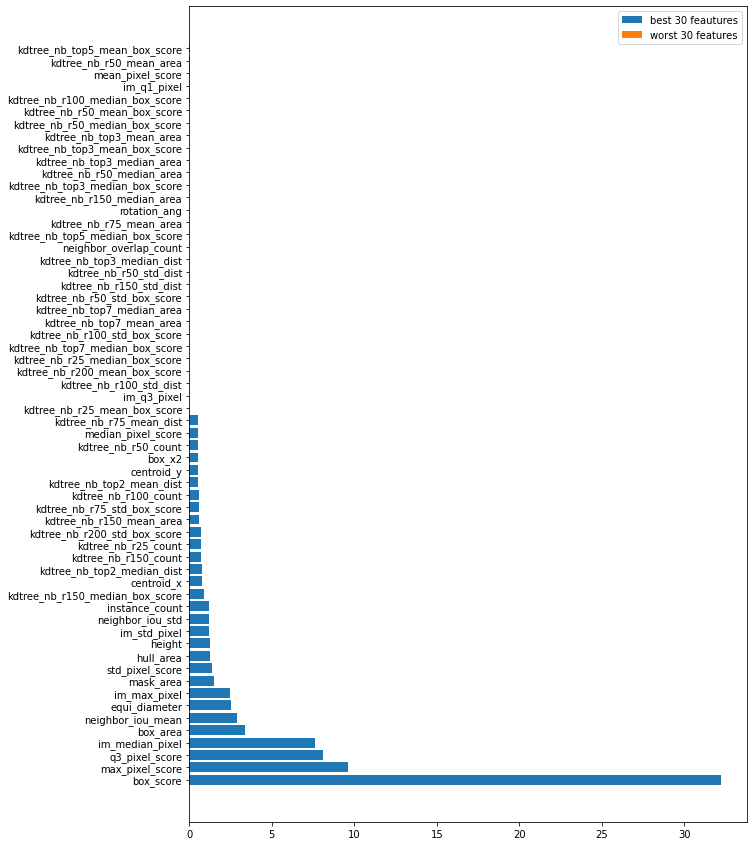

In [81]:
ft_imp = pd.DataFrame({'features':X_cols2, 'importance':model.feature_importances_})
plt.figure(figsize=(10,15))

TOP = 30
ft_imp = ft_imp.sort_values('importance', ascending=False)
plt.barh(ft_imp['features'].iloc[:TOP], ft_imp['importance'].iloc[:TOP], label=f'best {TOP} feautures')
ft_imp = ft_imp.sort_values('importance', ascending=True)
plt.barh(ft_imp['features'].iloc[:TOP], ft_imp['importance'].iloc[:TOP], label=f'worst {TOP} features')

plt.legend()

In [82]:
mean_absolute_error(y_pred_train, y_train)

0.13651988321045178

In [83]:
mean_absolute_error(y_pred_valid, y_valid)

0.16070934591304514

In [84]:
train_df['pred_iou'] = y_pred_train
valid_df['pred_iou'] = y_pred_valid

In [85]:
train_df['FP'] = train_df['iou'] < 0.5
valid_df['FP'] = valid_df['iou'] < 0.5

In [86]:
train_df['FP'].value_counts()

False    4448
True     1266
Name: FP, dtype: int64

In [87]:
valid_df['FP'].value_counts()

False    5214
True     1444
Name: FP, dtype: int64

In [88]:
train_df['pred_FP'] = train_df['pred_iou'] < 0.3
valid_df['pred_FP'] = valid_df['pred_iou'] < 0.3

In [89]:
precision_score(train_df['FP'], train_df['pred_FP'])

0.9259259259259259

In [90]:
precision_score(valid_df['FP'], valid_df['pred_FP'])

0.8444444444444444

In [91]:
# roc_auc_score(train_df['iou']>=0.5, train_df['pred_iou'])

In [92]:
train_df['pred_FP'].sum(), valid_df['pred_FP'].sum()

(54, 45)

In [93]:
valid_df[valid_df.pred_FP == 1].image_id.unique()

array(['0f08d640930b', '1cc3b45e0399', '24a07145b24d', '29efe1120825',
       '2c7b7d0a1573', '3ac59a41a300', '4c98ec6b42aa', '576c680c66c7',
       '58b543a236c8', '5d066f4c3eef', '68780361eded', '7ca93f81e669',
       '82c638427f2f', '8a754409504b', '8bcc2ef2e81e', '98fd9ed43654',
       'a28407ce196e', 'a55cec7ee7a1', 'ae509c50607a', 'b861811eaff6',
       'bfb878cd992e', 'c3b32460bcba', 'de504eaa5349', 'f2e0ce316b7e',
       'fac5fa0dd448'], dtype=object)

In [69]:
image_id = '5d066f4c3eef'
for d in valid_ds2:
    if(d['image_id'] == image_id):
        break

PKL_FOLDER = get_pkl_folder(d)
path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'

with open(path, 'rb') as f:
    outputs = pickle.load(f)
    outputs['instances'] = outputs['instances'].to('cpu')
    
outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
print(AP, TP, FP, FN)
print_log(log)

0.2023048637815977 152.8 321.2 394.2
0.5 {'AP': 0.5238805970149254, 'TP': 351, 'FP': 123, 'FN': 196}
0.55 {'AP': 0.4544159544159544, 'TP': 319, 'FP': 155, 'FN': 228}
0.6 {'AP': 0.3649732620320856, 'TP': 273, 'FP': 201, 'FN': 274}
0.65 {'AP': 0.2714819427148194, 'TP': 218, 'FP': 256, 'FN': 329}
0.7 {'AP': 0.1927570093457944, 'TP': 165, 'FP': 309, 'FN': 382}
0.75 {'AP': 0.11706783369803063, 'TP': 107, 'FP': 367, 'FN': 440}
0.8 {'AP': 0.07247899159663866, 'TP': 69, 'FP': 405, 'FN': 478}
0.85 {'AP': 0.023046092184368736, 'TP': 23, 'FP': 451, 'FN': 524}
0.9 {'AP': 0.0029469548133595285, 'TP': 3, 'FP': 471, 'FN': 544}
0.95 {'AP': 0.0, 'TP': 0, 'FP': 474, 'FN': 547}


In [70]:
TP_list = valid_df[(valid_df['image_id'] == image_id) & (valid_df['pred_FP']==0)].instance_num.tolist()

In [71]:
outputs['instances'] = outputs['instances'][TP_list]

In [72]:
AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
print(AP, TP, FP, FN)
print_log(log)

0.20257629456789733 152.8 320.2 394.2
0.5 {'AP': 0.5246636771300448, 'TP': 351, 'FP': 122, 'FN': 196}
0.55 {'AP': 0.4550641940085592, 'TP': 319, 'FP': 154, 'FN': 228}
0.6 {'AP': 0.3654618473895582, 'TP': 273, 'FP': 200, 'FN': 274}
0.65 {'AP': 0.2718204488778055, 'TP': 218, 'FP': 255, 'FN': 329}
0.7 {'AP': 0.19298245614035087, 'TP': 165, 'FP': 308, 'FN': 382}
0.75 {'AP': 0.1171960569550931, 'TP': 107, 'FP': 366, 'FN': 440}
0.8 {'AP': 0.07255520504731862, 'TP': 69, 'FP': 404, 'FN': 478}
0.85 {'AP': 0.023069207622868605, 'TP': 23, 'FP': 450, 'FN': 524}
0.9 {'AP': 0.0029498525073746312, 'TP': 3, 'FP': 470, 'FN': 544}
0.95 {'AP': 0.0, 'TP': 0, 'FP': 473, 'FN': 547}


In [106]:
aaaaaaaaa

NameError: name 'aaaaaaaaa' is not defined

In [94]:
os.makedirs('stage2_model', exist_ok=True)

In [95]:
VER

'5_ens_m1022_m1018'

In [100]:
all_df = pd.concat([train_df, valid_df], axis=0)
model.fit(all_df[X_cols2].fillna(-1), all_df[y_col])

In [101]:
mean_absolute_error( all_df[y_col], model.predict(all_df[X_cols2].fillna(-1)))

0.14802895957058484

In [102]:
with open(os.path.join('stage2_model/', f'model_ver_{VER}.pkl'), 'wb') as f:
    pickle.dump(model, f)

In [99]:
pd.DataFrame(X_cols2, columns=['features']).to_csv(os.path.join('stage2_model/', f'features_ver_{VER}.csv'), index=False)

In [ ]:
aaaaaaaaaaaaaaa

In [ ]:
# Tune thresh

In [74]:
MASK_MIN_AREA = [70, 120, 50]

import torch
def filter_masks_by_area(mask_min_area, outputs):
    pred_class = torch.mode(outputs['instances'].pred_classes)[0]
    area_min = mask_min_area[pred_class]
    take = outputs['instances'].pred_masks.sum(axis=(1,2)) >= area_min
#     print(outputs['instances'].pred_masks.sum(axis=(1,2)))
    outputs['instances'] = outputs['instances'][take]
    return outputs

In [70]:
base_list_APs = []
base_image_ids = []
base_cell_types = []

for d in tqdm(valid_ds2, total=len(valid_ds2)):
    PKL_FOLDER = get_pkl_folder(d)
    path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'

    with open(path, 'rb') as f:
        outputs = pickle.load(f)
        outputs['instances'] = outputs['instances'].to('cpu')
    
    outputs = filter_masks_by_area(MASK_MIN_AREA, outputs)
    
    outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
    
    outputs = filter_masks_by_area(MASK_MIN_AREA, outputs)
    
    AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
    base_list_APs.append(AP)
    base_image_ids.append(d['image_id'])
    base_cell_types.append(d['annotations'][0]['category_id'])
    
base_result_df = pd.DataFrame({'image_id':base_image_ids, 'cell_type':base_cell_types, 'AP':base_list_APs})

  0%|          | 0/63 [00:00<?, ?it/s]

In [71]:
# np.mean(list_APs)  # baseline score: 0.3331

In [72]:
base_result_df.AP.mean()

0.3361197482630999

In [73]:
base_result_df.groupby('cell_type').AP.sum() / len(base_result_df)

cell_type
0    0.067692
1    0.055405
2    0.213023
Name: AP, dtype: float64

In [ ]:
0.3361197482630999

cell_type
0    0.067692
1    0.055405
2    0.213023


In [55]:
sub_valid_df = valid_df

for thresh in [0.1,0.2,0.3,0.4,0.5]:
    sub_valid_df['pred_FP'] = sub_valid_df['pred_iou'] < thresh
    print('=======================================================')
    print('Thresh:', thresh, '. Number of predicted FPs:', sub_valid_df['pred_FP'].sum(), 
          '. Precision:', precision_score(sub_valid_df['FP'], sub_valid_df['pred_FP']))
    
    list_APs = []

    for d in tqdm(valid_ds2, total=len(valid_ds2)):
        if(d['image_id'] not in sub_valid_df['image_id'].tolist()):
            continue
        PKL_FOLDER = get_pkl_folder(d)
        path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'
        
        image_id = d['image_id']
        TP_list = sub_valid_df[(sub_valid_df['image_id'] == image_id) & (sub_valid_df['pred_FP']==0)].instance_num.tolist()

        with open(path, 'rb') as f:
            outputs = pickle.load(f)
            outputs['instances'] = outputs['instances'].to('cpu')
            outputs['instances'] = outputs['instances'][TP_list]
            
        outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
        
        outputs = filter_masks_by_area(MASK_MIN_AREA, outputs)
        
        AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
        list_APs.append(AP)
        
    print('AP:', np.mean(list_APs))

In [75]:
import numpy as np
from hyperopt import hp

def objective(args):
    n_estimators, max_depth, learning_rate, reg_lambda, thresh = args['n_estimators'], args['max_depth'], \
                                        args['learning_rate'], args['reg_lambda'], args['thresh']
    
    model = CatBoostRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                        learning_rate=learning_rate, reg_lambda=reg_lambda,
                        loss_function='RMSE',
                         verbose=False, 
                        random_state=67,
                             thread_count=4)
    
    model.fit(X_train,y_train)
    y_pred_valid = model.predict(X_valid)
    
    sub_valid_df = valid_df
    sub_valid_df['pred_iou'] = y_pred_valid
    
    sub_valid_df['pred_FP'] = sub_valid_df['pred_iou'] < thresh
#     print('=======================================================')
#     print('Thresh:', thresh, '. Number of predicted FPs:', sub_valid_df['pred_FP'].sum(), 
#           '. Precision:', precision_score(sub_valid_df['FP'], sub_valid_df['pred_FP']))
    
    list_APs = []
    
    for d in tqdm(valid_ds2, total=len(valid_ds2)):
        if(d['image_id'] not in sub_valid_df['image_id'].tolist()):
            continue
        PKL_FOLDER = get_pkl_folder(d)
        path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'
        
        image_id = d['image_id']
        TP_list = sub_valid_df[(sub_valid_df['image_id'] == image_id) & (sub_valid_df['pred_FP']==0)].instance_num.tolist()

        with open(path, 'rb') as f:
            outputs = pickle.load(f)
            outputs['instances'] = outputs['instances'].to('cpu')
            outputs['instances'] = outputs['instances'][TP_list]
            
        outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
        
        try:
            outputs = filter_masks_by_area(MASK_MIN_AREA, outputs)

            AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])

        except Exception as ex:
            print(ex)
            AP, TP, FP, FN, log = 0,0,0,0,''
            
        list_APs.append(AP)
        
    mAP = np.mean(list_APs)
    print('Params:', args, '. AP:', mAP)
    return -mAP

space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
        'max_depth': hp.quniform('max_depth', 2, 4, 1),
        'learning_rate': hp.quniform('learning_rate', 0.01, 0.1, 0.01),
        'reg_lambda': hp.quniform('reg_lambda', 0.5, 2, 0.5),
        'thresh': hp.quniform('div5', 0.1, 0.5, 0.1)
}

# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest,
            max_evals=100, rstate=np.random.RandomState(67))

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                
{'learning_rate': 0.09, 'max_depth': 4.0, 'n_estimators': 500.0, 'reg_lambda': 1.0, 'thresh': 0.4}
. AP:                                                  
0.33297720447181756                                    
  1%|          | 1/100 [06:06<10:04:57, 366.65s/trial, best loss: -0.33297720447181756]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                                
{'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 900.0, 'reg_lambda': 1.0, 'thresh': 0.4}
. AP:                                                                                  
0.334369384128605                                                                      
  2%|▏         | 2/100 [07:29<5:26:24, 199.84s/trial, best loss: -0.334369384128605]   

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                             
{'learning_rate': 0.09, 'max_depth': 3.0, 'n_estimators': 900.0, 'reg_lambda': 1.0, 'thresh': 0.5}
. AP:                                                                               
0.32689633473074503                                                                 
  3%|▎         | 3/100 [08:43<3:49:56, 142.23s/trial, best loss: -0.334369384128605]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                             
{'learning_rate': 0.04, 'max_depth': 3.0, 'n_estimators': 300.0, 'reg_lambda': 0.5, 'thresh': 0.2}
. AP:                                                                               
0.33606050833165235                                                                 
  4%|▍         | 4/100 [10:14<3:15:15, 122.03s/trial, best loss: -0.33606050833165235]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 600.0, 'reg_lambda': 0.5, 'thresh': 0.1}
. AP:                                                                                 
0.33610914583886586                                                                   
  5%|▌         | 5/100 [11:52<2:59:14, 113.21s/trial, best loss: -0.33610914583886586]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.07, 'max_depth': 2.0, 'n_estimators': 800.0, 'reg_lambda': 0.5, 'thresh': 0.4}
. AP:                                                                                 
0.3328299542200456                                                                    
  6%|▌         | 6/100 [13:29<2:48:53, 107.81s/trial, best loss: -0.33610914583886586]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.02, 'max_depth': 4.0, 'n_estimators': 600.0, 'reg_lambda': 2.0, 'thresh': 0.4}
. AP:                                                                                 
0.3348988078053257                                                                    
  7%|▋         | 7/100 [15:11<2:44:15, 105.97s/trial, best loss: -0.33610914583886586]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.06, 'max_depth': 2.0, 'n_estimators': 300.0, 'reg_lambda': 0.5, 'thresh': 0.4}
. AP:                                                                                 
0.33535157539335003                                                                   
  8%|▊         | 8/100 [17:04<2:45:48, 108.14s/trial, best loss: -0.33610914583886586]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 700.0, 'reg_lambda': 1.0, 'thresh': 0.30000000000000004}
. AP:                                                                                 
0.3369210528947711                                                                    
  9%|▉         | 9/100 [19:06<2:50:38, 112.51s/trial, best loss: -0.3369210528947711] 

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                              
{'learning_rate': 0.07, 'max_depth': 2.0, 'n_estimators': 800.0, 'reg_lambda': 1.5, 'thresh': 0.4}
. AP:                                                                                
0.3352534148068643                                                                   
 10%|█         | 10/100 [21:05<2:51:59, 114.67s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.08, 'max_depth': 3.0, 'n_estimators': 400.0, 'reg_lambda': 1.5, 'thresh': 0.4}
. AP:                                                                                 
0.3348170255576406                                                                    
 11%|█         | 11/100 [23:02<2:51:06, 115.36s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.08, 'max_depth': 2.0, 'n_estimators': 300.0, 'reg_lambda': 0.5, 'thresh': 0.2}
. AP:                                                                                 
0.3360823723972076                                                                    
 12%|█▏        | 12/100 [25:05<2:52:15, 117.45s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 300.0, 'reg_lambda': 1.0, 'thresh': 0.2}
. AP:                                                                                 
0.33610914583886586                                                                   
 13%|█▎        | 13/100 [27:19<2:57:46, 122.60s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.02, 'max_depth': 3.0, 'n_estimators': 500.0, 'reg_lambda': 2.0, 'thresh': 0.4}
. AP:                                                                                 
0.33460710876460664                                                                   
 14%|█▍        | 14/100 [29:33<3:00:31, 125.95s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

Params:                                                                               
{'learning_rate': 0.03, 'max_depth': 4.0, 'n_estimators': 200.0, 'reg_lambda': 2.0, 'thresh': 0.5}
. AP:                                                                                 
0.3339191793493077                                                                    
 15%|█▌        | 15/100 [31:36<2:57:25, 125.25s/trial, best loss: -0.3369210528947711]

  0%|          | 0/63 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [31:45<2:59:59, 127.06s/trial, best loss: -0.3369210528947711]


KeyboardInterrupt: 

In [ ]:
{'learning_rate': 0.02, 'max_depth': 2.0, 'n_estimators': 700.0, 'reg_lambda': 1.0, 'thresh': 0.30000000000000004}
. AP:                                                                                 
0.33682791971468246  


In [643]:
best.values()

NameError: name 'best' is not defined

In [645]:
print('Thresh:', thresh, '. Number of predicted FPs:', sub_valid_df['pred_FP'].sum(), 
          '. Precision:', precision_score(sub_valid_df['FP'], sub_valid_df['pred_FP']))

Thresh: 0.5 . Number of predicted FPs: 44 . Precision: 0.7272727272727273


In [647]:
model.__dict__

{'_init_params': {'reg_lambda': 1,
  'random_state': 67,
  'n_estimators': 700,
  'max_depth': 2,
  'verbose': False,
  'loss_function': 'RMSE',
  'learning_rate': 0.05},
 '_object': <_catboost._CatBoost at 0x7fe2880dbce0>,
 '_random_seed': 67,
 '_learning_rate': 0.05000000074505806,
 '_tree_count': 700,
 '_n_features_in': 147,
 '_prediction_values_change': [22.884270802088913,
  1.8826372138336254,
  1.5582581631600205,
  0.5537552972311844,
  0.5132027078405437,
  0.746936053492996,
  0.5209117596677774,
  0.17309710756439275,
  0.7674109844521868,
  0.42798450807122373,
  2.4130421978922767,
  0.343385236466311,
  0.0,
  0.16795477812444295,
  0.09594882630274836,
  0.5895292784237247,
  0.8049625583839563,
  3.6312781660073927,
  0.921378067653004,
  0.36718539284031876,
  0.1293113412870325,
  0.39061751409615564,
  0.26672653776782246,
  0.5659599987903579,
  0.3410228772894565,
  6.5882841486337025,
  1.4156796740355424,
  0.05154393246184105,
  0.10199164227169863,
  6.01011097

In [ ]:
ls

In [ ]:
list_APs = [] 
image_ids = []
cell_types = []
TPs = []
FPs = []
FNs = []
logs = []

thresh = 0.3
valid_df['pred_FP'] = valid_df['pred_iou'] < thresh
print('=======================================================')
print('Thresh:', thresh, '. Number of predicted FPs:', valid_df['pred_FP'].sum(), 
      '. Precision:', precision_score(valid_df['FP'], valid_df['pred_FP']))

list_APs = []

for d in tqdm(valid_ds2, total=len(valid_ds2)):
    PKL_FOLDER = get_pkl_folder(d)
    path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'

    image_id = d['image_id']
    TP_list = valid_df[(valid_df['image_id'] == image_id) & (valid_df['pred_FP']==0)].instance_num.tolist()

    with open(path, 'rb') as f:
        outputs = pickle.load(f)
        outputs['instances'] = outputs['instances'].to('cpu')
        outputs['instances'] = outputs['instances'][TP_list]

    outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
    AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
    list_APs.append(AP)
    image_ids.append(d['image_id'])
    cell_types.append(d['annotations'][0]['category_id'])
    TPs.append(TP)
    FPs.append(FP)
    FNs.append(FN)
    logs.append(log)

print('AP:', np.mean(list_APs))
result_df = pd.DataFrame({'image_id':image_ids, 'cell_type':cell_types, 'AP':list_APs,
                              'TP':TPs, 'FP':FPs, 'FN':FNs, 'log':logs})

In [ ]:
result_df.groupby('cell_type').AP.sum() / len(result_df)

In [80]:
import torch

In [112]:
# filter by mask min area
list_APs = [] 
image_ids = []
cell_types = []
TPs = []
FPs = []
FNs = []
logs = []

thresh = 0.3
valid_df['pred_FP'] = valid_df['pred_iou'] < thresh
print('=======================================================')
print('Thresh:', thresh, '. Number of predicted FPs:', valid_df['pred_FP'].sum(), 
      '. Precision:', precision_score(valid_df['FP'], valid_df['pred_FP']))

list_APs = []

for d in tqdm(valid_ds2, total=len(valid_ds2)):
    PKL_FOLDER = get_pkl_folder(d)
    path = f'{PKL_FOLDER}/{d["image_id"]}.pkl'

    image_id = d['image_id']
    TP_list = valid_df[(valid_df['image_id'] == image_id) & (valid_df['pred_FP']==0)].instance_num.tolist()

    with open(path, 'rb') as f:
        outputs = pickle.load(f)
        outputs['instances'] = outputs['instances'].to('cpu')
        outputs['instances'] = outputs['instances'][TP_list]
        
    outputs = filter_masks_by_area(MASK_MIN_AREA, outputs)

    outputs['instances'].pred_masks = outputs['instances'].pred_masks >= 0.5
    AP, TP, FP, FN, log = calculate_AP(outputs, d['annotations'])
    list_APs.append(AP)
    image_ids.append(d['image_id'])
    cell_types.append(d['annotations'][0]['category_id'])
    TPs.append(TP)
    FPs.append(FP)
    FNs.append(FN)
    logs.append(log)

print('AP:', np.mean(list_APs))
result_df = pd.DataFrame({'image_id':image_ids, 'cell_type':cell_types, 'AP':list_APs,
                              'TP':TPs, 'FP':FPs, 'FN':FNs, 'log':logs})

Thresh: 0.3 . Number of predicted FPs: 68 . Precision: 0.7647058823529411


  0%|          | 0/63 [00:00<?, ?it/s]

AP: 0.33642561029835016


In [113]:
result_df.groupby('cell_type').AP.sum() / len(result_df)

cell_type
0    0.067655
1    0.055549
2    0.213221
Name: AP, dtype: float64